In [11]:
%%capture
%pip install texthero vaderSentiment sidetable nltk pyldavis;
import warnings
warnings.filterwarnings('ignore')
#necessary libraries for topic-modeling
import warnings
warnings.filterwarnings('ignore')
#necessary libraries for topic-modeling
import numpy as np
import pandas as pd
# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
#postgre connection import
import psycopg2
import texthero as hero
%matplotlib inline
# spacy for lemmatization
import spacy

# import text processing libraries
import texthero as hero
from texthero import preprocessing as pp

import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords

from gensim.corpora import Dictionary
from texthero import preprocessing as pp

In [12]:
#connecting to the database
conn = psycopg2.connect("dbname = 'postgres' user = 'cpdbstudent' host = 'codd01.research.northwestern.edu' password = 'DataSci4AI'")
cur = conn.cursor()
query = """
SELECT summary from data_allegation,(SELECT name, id, median_income
FROM  data_area
WHERE median_income IS NOT NULL
ORDER BY CAST( replace(replace(median_income, '$',''),',','') AS INT )DESC
LIMIT 5)b, data_allegation_areas where data_allegation.crid = data_allegation_areas.allegation_id and
                                       data_allegation_areas.area_id = b.id and not data_allegation.summary  = ''
"""
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query)
with open('data_attachmentfile.csv', 'w') as f:
    cur.copy_expert(outputquery, f)

In [13]:
train = pd.read_csv("data_attachmentfile.csv")
train=train.dropna()
cpdp_text = train["summary"].values
df2 = train

In [14]:
cpdp_text[1]

'On April 23, 2018, Officer was off?duty and involved in a verbal altercation with her husband, former Chicago Police Officer over washing dishes and that altercation became physical. Mr. stated to COPA and in Department records that Officer initiated the physical altercation by jumping onto his back, ripping his shirt, and scratching him on his back and neck. Mr. alleged that Officer then opened the garage door and falsely screamed that she needed help because Mr. had hit her and taken her phone. Mr. _stated that Officer then picked up their three?year?old son, and took him to the home of their next?door neighbor, Mr. _then called 911. Police responded to the residence, and Mr. declined medical attention. Evidence Technician photographs of Mr. documented that the neck of his shirt appeared stretched and torn and redness and scratches on the middle of his back and on both sides of his neck. Mr. _further alleged that Officer had not properly secured her weapon within the marital residen

In [15]:
def cleaner(df):
    print('======================================== Start Cleaning')
    pipeline = [pp.fillna
                , pp.remove_digits
                , pp.lowercase
                , pp.remove_punctuation
                , pp.remove_diacritics
                , pp.remove_stopwords
                , pp.remove_whitespace
                , pp.stem
                ]
    print('======================================== Done Cleaning')
    df['summary'] = hero.clean(df['summary'], pipeline=pipeline)
    print('======================================== DataFrame Head')
    return df
df_clean = cleaner(df2)

======================================== Start Cleaning
======================================== Done Cleaning
======================================== DataFrame Head


In [16]:
print('Prep Tables for NLP Analysis')
narrative_content = ''
for i in range(df_clean.shape[0]):
    if i == 0:
        narrative_content = df_clean['summary'][i]
    else:
        narrative_content += df_clean['summary'][i]
tokens = word_tokenize(narrative_content)

Prep Tables for NLP Analysis


In [17]:
spacy.load('en_core_web_sm')
quotes = spacy.lang.punctuation.LIST_QUOTES
punct = spacy.lang.punctuation.LIST_PUNCT
stop_words = stopwords.words("english")
num=['0','1','2','3','4','5','6','7','8','9','&','-','',"'","--"]
other = ['b','initi','alleg','intak','report','accus','without','none','state','find','offic']
trunc = num + punct + quotes+other+stop_words

filtered_tokens = []
for i in tokens:
    if i not in trunc:
        filtered_tokens.append(i)
print('Show Filtered Tokens')
print(filtered_tokens[:50])

Show Filtered Tokens
['detect', 'ex', 'husband', 'lieuten', 'struck', 'detect', 'vehicl', 'slam', 'door', 'caus', 'strike', 'detect', 'detect', 'lieuten', 'fail', 'notifi', 'chicago', 'polic', 'depart', 'lieuten', 'investig', 'depart', 'children', 'famili', 'servicapril', 'duti', 'involv', 'verbal', 'alterc', 'husband', 'former', 'chicago', 'polic', 'wash', 'dish', 'alterc', 'becam', 'physic', 'mr', 'copa', 'depart', 'record', 'physic', 'alterc', 'jump', 'onto', 'back', 'rip', 'shirt', 'scratch']


In [18]:
unique_words = []
for word in filtered_tokens:
    if word not in unique_words:
        unique_words.append(word)
print('Number of Unique Words')
print(len(unique_words))

Number of Unique Words
850


In [19]:
id2word = Dictionary([filtered_tokens])
corpus = [id2word.doc2bow([text]) for text in filtered_tokens]

for c in corpus:
    print(c[0])
    if c[0][1] > 1:
        print(c)
    break
print('Shape of Corpus')
print(corpus[:1])

(230, 1)
Shape of Corpus
[[(230, 1)]]


In [20]:
unique_words = []
for word in filtered_tokens:
    if word not in unique_words:
        unique_words.append(word)
print('Number of Unique Words')
print(len(unique_words))

Number of Unique Words
850


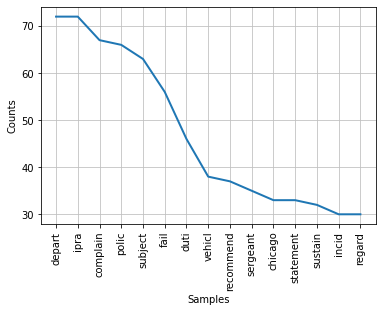

In [21]:
#@title
word_freq = nltk.FreqDist(filtered_tokens)
word_freq.plot(15)

In [22]:
print('Top 10 Most Frequent Words')
word_freq.most_common(10)

Top 10 Most Frequent Words


[('depart', 72),
 ('ipra', 72),
 ('complain', 67),
 ('polic', 66),
 ('subject', 63),
 ('fail', 56),
 ('duti', 46),
 ('vehicl', 38),
 ('recommend', 37),
 ('sergeant', 35)]

In [23]:
def generate_ngrams(text, n):
    ngrams = zip(*[text[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

bigram_freq = {}
for i in range(len(filtered_tokens)-1):
    bigram = (filtered_tokens[i],  filtered_tokens[i+1])
    if bigram not in bigram_freq:
        bigram_freq[bigram] = 0
    bigram_freq[bigram] += 1
        
trigram_freq = {}
for i in range(len(filtered_tokens)-2):
    trigram = (filtered_tokens[i],  filtered_tokens[i+1], filtered_tokens[i+2])
    if trigram not in trigram_freq:
        trigram_freq[trigram] = 0
    trigram_freq[trigram] += 1

print("Total corpa: ",len(filtered_tokens))
print("Total bigrams: ",len(bigram_freq))
print("Total trigrams: ",len(trigram_freq))

Total corpa:  3280
Total bigrams:  2164
Total trigrams:  2511


In [24]:
from gensim.models.ldamodel import LdaModel
import pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [25]:
%%capture
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)
doc_lda = lda_model[corpus]

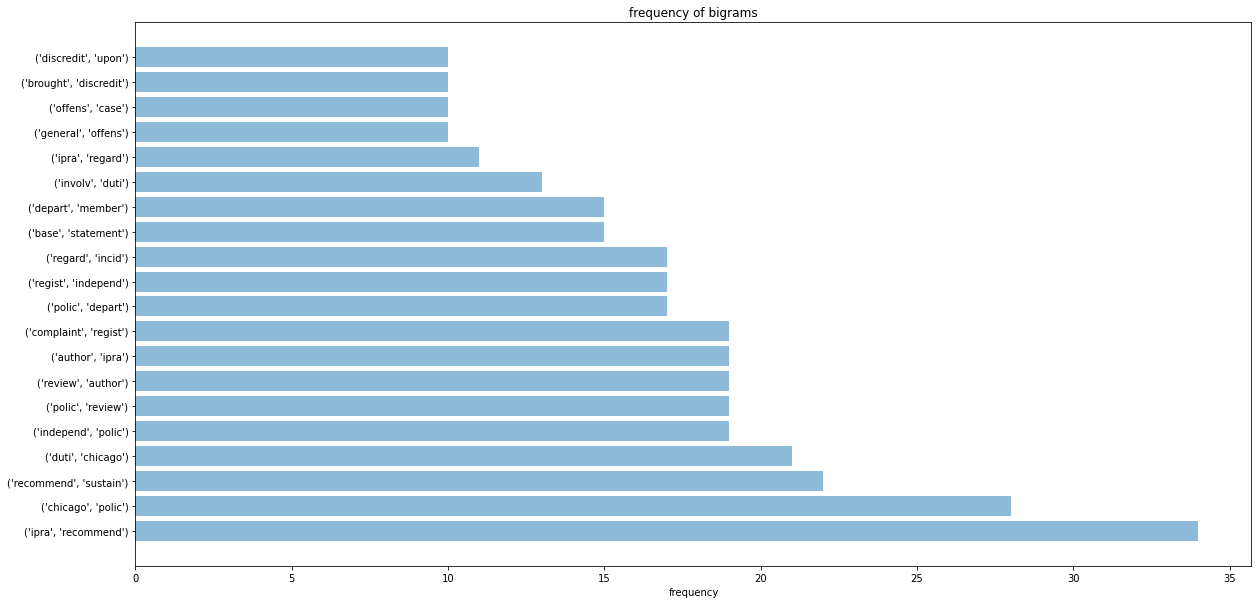

In [26]:
sorted_bigram_freq = sorted(bigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_bigram_freq)):
    phrases.append(sorted_bigram_freq[x][0])
    freq.append(sorted_bigram_freq[x][1])
phrases = phrases[:20]
freq = freq[:20]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of bigrams')
plt.show()

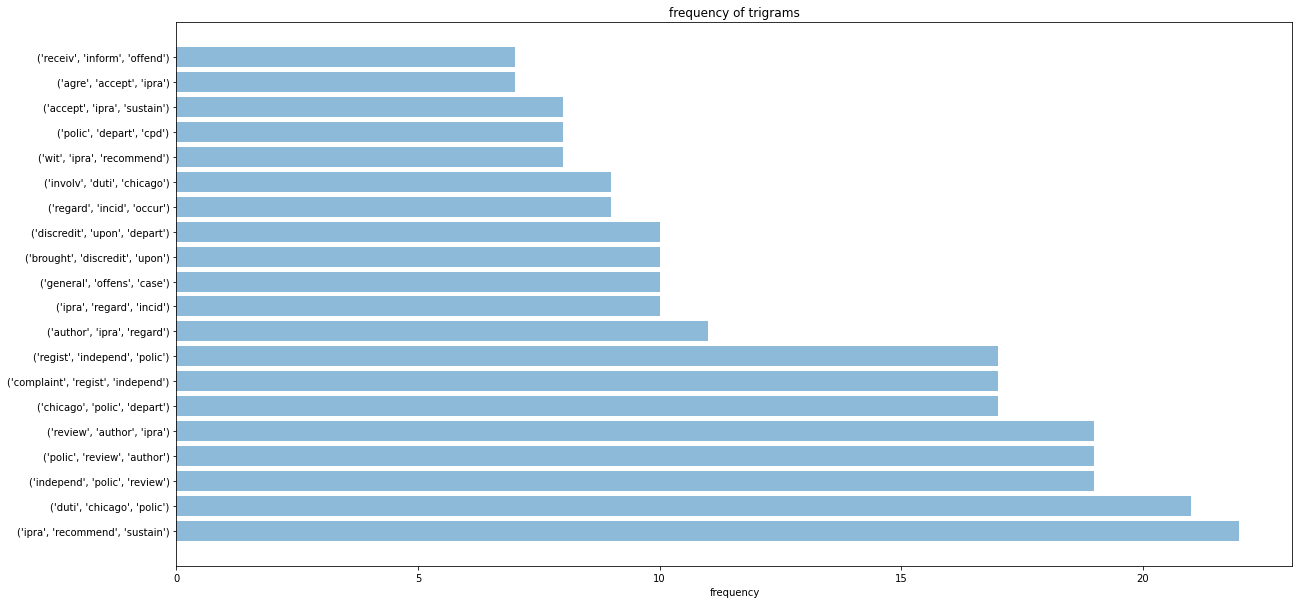

In [27]:
sorted_trigram_freq = sorted(trigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_trigram_freq)):
    phrases.append(sorted_trigram_freq[x][0])
    freq.append(sorted_trigram_freq[x][1])

phrases = phrases[:20]
freq = freq[:20]
y_pos = np.arange(len(phrases))

plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of trigrams')
plt.show()

In [28]:
!pip install -U sentence-transformers

     |████████████████████████████████| 78 kB 3.4 MB/s 
     |████████████████████████████████| 3.1 MB 15.4 MB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
     |████████████████████████████████| 1.2 MB 54.9 MB/s 
     |████████████████████████████████| 61 kB 414 kB/s 
     |████████████████████████████████| 895 kB 55.9 MB/s 
     |████████████████████████████████| 596 kB 50.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=8482c64ecb701fbc685dc1b39a2d00283f2611df753a50d8b5bf7f405ee2b879
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [29]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Our sentences we like to encode
# sentences = ['This framework generates embeddings for each input sentence',
#     'Sentences are passed as a list of string.',
#     'The quick brown fox jumps over the lazy dog.']

# #Sentences are encoded by calling model.encode()
# embeddings = model.encode(sentences)

# #Print the embeddings
# for sentence, embedding in zip(sentences, embeddings):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding)
#     print("")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [50]:
#connecting to the database
query = """
    select a.summary, c.median_income::money::numeric as income from data_allegation a join
(SELECT DISTINCT ON(1) table1.id as beat_id, table2.id as community_id FROM
                                                                (SELECT * FROM  data_area WHERE data_area.area_type ='beat')table1,
                                                                (SELECT * FROM  data_area WHERE data_area.area_type ='community')table2
               WHERE ST_Contains(table2.polygon, table1.polygon) or st_intersects(table2.polygon, table1.polygon) ) b on a.beat_id=b.beat_id
join data_area c on b.community_id = c.id
    WHERE not summary = ''  
"""
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query)
with open('data_attachmentfile2.csv', 'w') as f:
    cur.copy_expert(outputquery, f)

# Loading in the training data with Pandas
train_ori = pd.read_csv("data_attachmentfile2.csv")

train=train_ori.summary.dropna()

print(train.shape)

(1105,)


In [51]:
train.head()

0    On October 25, 2011, a complaint was registere...
1    On December 5, 2011, a complaint was registere...
2    On November 13, 2011, a complaint was register...
3    On February 1, 2012, a complaint was registere...
4    On March 3, 2012, a complaint was registered w...
Name: summary, dtype: object

In [52]:
from numpy import dot
from numpy.linalg import norm

embeddings = model.encode(np.array(train))

In [53]:
res = []

for a in embeddings:
  for b in embeddings:
    res.append(dot(a, b)/(norm(a)*norm(b)))
res = np.array(res)

In [54]:
res = res.reshape(-1, len(train))
print(res.shape)

(1105, 1105)


In [55]:
df = pd.DataFrame(res)

In [56]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(list(range(res.shape[0])))


In [57]:
for i in range(res.shape[0]):
  neighbors = df.loc[:, i].nlargest(2).index.tolist()
  # print(neighbors)
  G.add_edges_from([(i,j) for i in neighbors for j in neighbors if i > j])

In [58]:
# nx.connected_components(G)
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True) if len(c) >= 15]

[58, 40, 35, 26, 23, 22, 22, 21, 21, 21, 18, 18, 16, 16, 15]

In [ ]:
train_ori_map = {i: train_ori.iloc[i, 1] for i in range(train_ori.shape[0])}

In [ ]:
avg_income = []

for c in sorted(nx.connected_components(G), key=len, reverse=True):
  if len(c) >= 15:
    avg_income.append(np.mean(list(map(lambda x: train_ori_map[x], c))))

In [ ]:
avg_income

[50464.18965517241,
 49322.6,
 45312.4,
 50771.42307692308,
 41052.608695652176,
 44056.13636363636,
 33738.36363636364,
 42120.619047619046,
 47985.380952380954,
 46466.666666666664,
 46018.444444444445,
 49241.38888888889,
 39037.5625,
 34008.4375,
 52417.13333333333]

In [ ]:
np.mean(np.array(train_ori.iloc[:,1]))

45572.10407239819